In [63]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
phi_data = pd.read_json("phi-1.5/phi_entropies_tinystories_data.json")
mpt_data = pd.read_json("mpt-7b/mpt_entropies_tinystories_data.json")

The data that comes out of the `process_data` function is of the form `(layers, heads, n)`, where `n` is the last n tokens taken, `heads` is the number of heads in the model, and `layers` is the number of layers in the model. The function averages the entropy across all the stories in the dataset (in this case, 1000) and returns the Tensor of all the averages.

In [65]:
def process_data(data, num_layers, num_heads):
    n = 20 # we take the last 20 tokens of the data
    avg_entropies = torch.zeros((num_layers, num_heads, n))
    for storynum, story in enumerate(data):
        for layernum in range(num_layers):
            # for a certain story and a certain layer:
            last_n_entropy = torch.Tensor(data[story][f'layer {layernum}']['last_n_entropy'])
            avg_entropies[layernum] += last_n_entropy[0]

    avg_entropies /= (storynum+1)
    return avg_entropies

In [66]:
def max_entropy(seq_len):
    a = torch.Tensor([1/seq_len for _ in range(seq_len)])
    max_a = -torch.sum(a*torch.log(a))
    return max_a

def pretty_graph(avg_entropies, num_layers, model_name=""):
    blue, orange, green, red = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'

    last_token_avg_entropies = avg_entropies[...,-1]
    fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
    for layernum,layer in enumerate(last_token_avg_entropies):
        y2 = layer.tolist()
        axes2.scatter([layernum+1 for _ in range(len(y2))], y2, c=blue)
    x = [i for i in range(1,num_layers+1)]
    y = torch.mean(avg_entropies, dim=-2)[:,-1].tolist()   
    axes2.plot(x,y, c='k', linewidth=5)
    axes2.set(title=f"{model_name}: Entropy of the last tokens attention vector", xlabel='layer number', ylabel='Entropy, averaged across 1000 sentences')
    plt.axhline(0, c='k')
    plt.axhline(max_entropy(200), c='k')
    plt.axhline(max_entropy(50), c=green, linestyle='--', label='75% sparse')
    plt.axhline(max_entropy(20), c=orange, linestyle='--', label='90% sparse')
    plt.axhline(max_entropy(2), c=red, linestyle='--', label='99% sparse')
    plt.legend()
    plt.show()

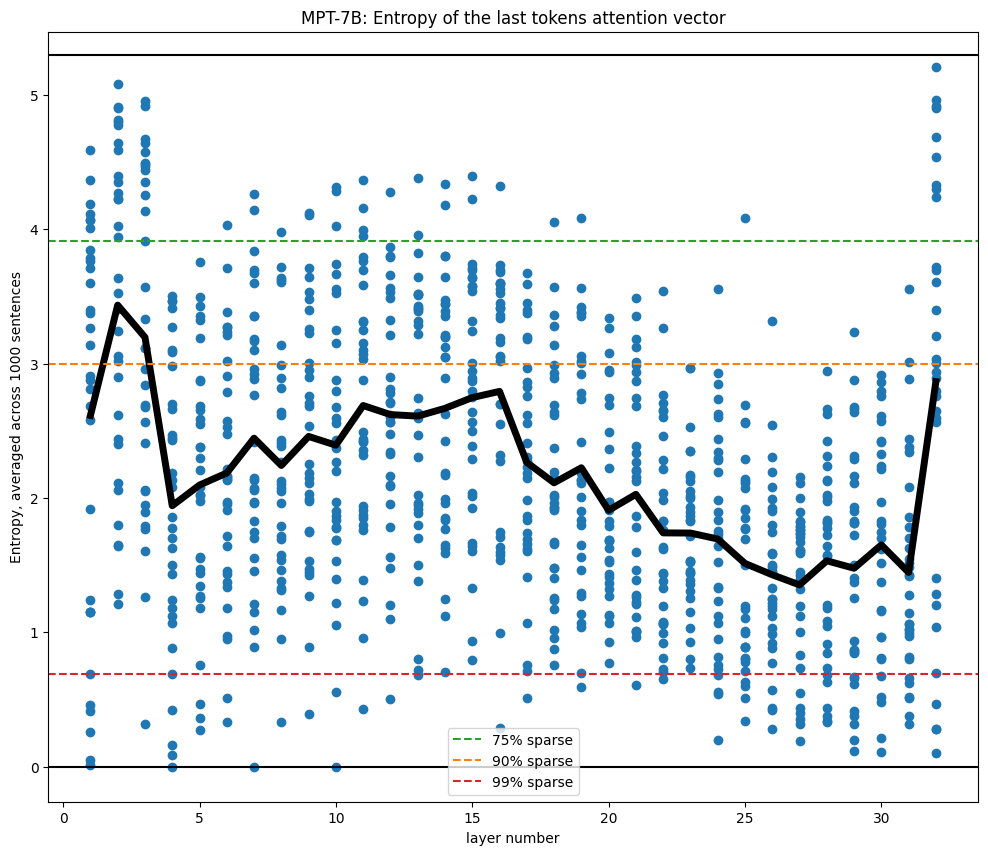

In [67]:
mpt_processed = process_data(mpt_data, num_layers=32, num_heads=32)
pretty_graph(mpt_processed, num_layers=32, model_name="MPT-7B")

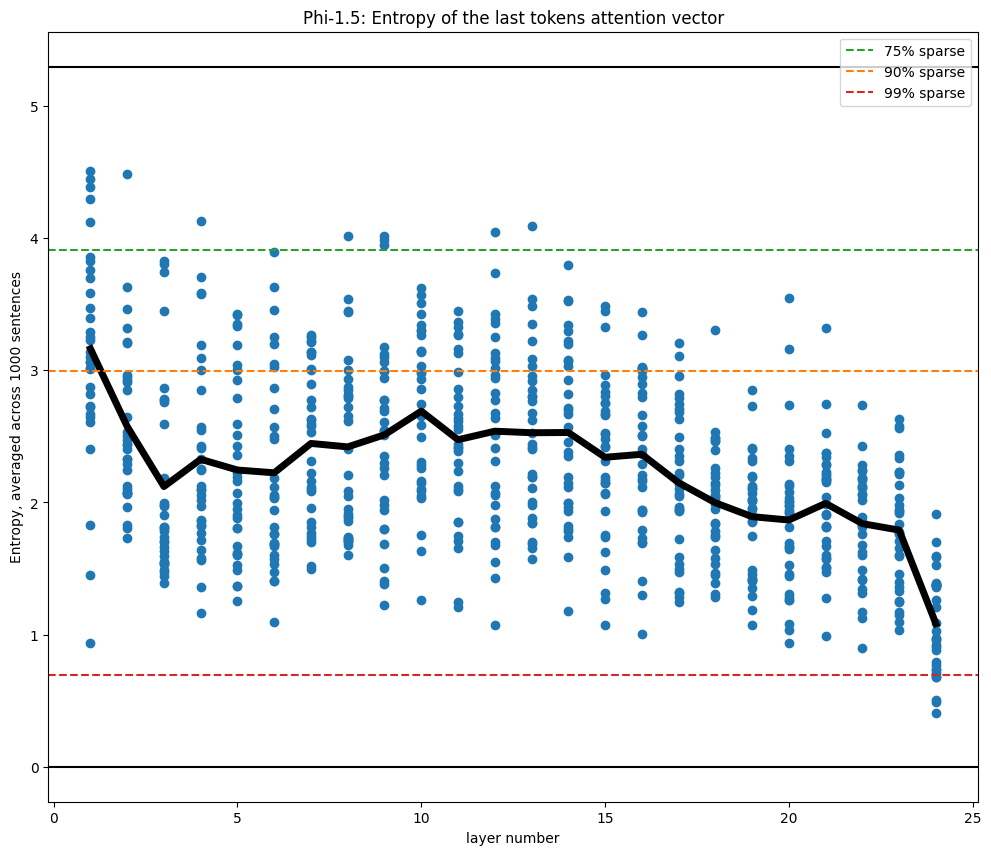

In [68]:
phi_processed = process_data(phi_data, num_layers=24, num_heads=32)
pretty_graph(phi_processed, num_layers=24, model_name="Phi-1.5")